In [2]:
import math
import os
import torch
import torch.nn as nn
import time
import numpy as np
import torch.optim as optim
import torchvision
from torch.autograd import Variable
import subprocess
from models import GetModel, ESRGAN_Discriminator, ESRGAN_FeatureExtractor
from datahandler import GetDataloaders

from torch.utils.tensorboard import SummaryWriter

from options import parser
import traceback
import socket
from datetime import datetime

import sys

from skimage import io
import scipy.misc
from scipy import ndimage
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import skimage
# from skimage.metrics import structural_similarity
from skimage.measure import compare_ssim
import torchvision.transforms as transforms
import numpy as np
import time
from PIL import Image
import scipy.ndimage as ndimage
import torch.nn as nn
import os

In [17]:
import argparse
import models

opt = argparse.Namespace()
self = argparse.Namespace()
opt.n_resgroups = 3
opt.n_resblocks = 3
opt.n_feats = 64
opt.reduction = 16
opt.narch = 0
opt.scale = 1
opt.nch_in = 50
opt.nch_out = 50
opt.norm = ''
opt.task = 'simingtout'
opt.lr = 1e-4
net = models.RCAN(opt)

self.scale = opt.scale
self.task = opt.task
self.nch_in = opt.nch_in
self.nch_out = opt.nch_out
self.norm = opt.norm

not using normalization


In [29]:
stack = io.imread("G:/My Drive/01datasets/Deconvolution/DIV2K_3D_convolution_20200916/0000.tif")

inputimg = stack[:self.nch_in]

# adding noise
# if 'noiseRetraining' in self.out:
#     noisefrac = np.linspace(0,1,10)
#     idx = np.random.randint(0,10)
#     inputimg = inputimg + noisefrac[idx]*np.std(I)*np.random.randn(*inputimg.shape)
#     inputimg = np.clip(inputimg,0,255).astype('uint16')

if self.nch_in == 6:
    inputimg = inputimg[[0,1,3,4,6,7]]
elif self.nch_in == 3:
    inputimg = inputimg[[0,4,8]]

if len(stack) > 9:
    # otf = stack[9]
    if self.scale == 2:
        toprow = np.hstack((stack[-4,:,:],stack[-2,:,:]))
        botrow = np.hstack((stack[-3,:,:],stack[-1,:,:]))
        gt = np.vstack((toprow,botrow)).reshape(2*stack.shape[1],2*stack.shape[2])
    elif self.nch_out > 1:
        gt = stack[-self.nch_out:]
    else:
        gt = stack[-1] # used to be index self.nch_in+1
else:
    gt = stack[0] # if it doesn't exist, doesn't matter


# widefield = stack[12]

# print('max before:',end=' ')
# print('%0.2f %0.2f %0.2f %0.2f %0.2f' % (np.max(inputimg),np.max(otf),np.max(gt),np.max(simimg),np.max(widefield)))

if self.norm == 'convert': # raw img from microscope, needs normalisation and correct frame ordering
    print('Raw input assumed - converting')
    # NCHW
    # I = np.zeros((9,opt.imageSize,opt.imageSize),dtype='uint16')

    # for t in range(9):
    #     frame = inputimg[t]
    #     frame = 120 / np.max(frame) * frame
    #     frame = np.rot90(np.rot90(np.rot90(frame)))
    #     I[t,:,:] = frame
    # inputimg = I

    inputimg = np.rot90(inputimg,axes=(1,2))
    inputimg = inputimg[[6,7,8,3,4,5,0,1,2]] # could also do [8,7,6,5,4,3,2,1,0]
    for i in range(len(inputimg)):
        inputimg[i] = 100 / np.max(inputimg[i]) * inputimg[i]
elif 'convert' in self.norm:
    fac = float(self.norm[7:])
    inputimg = np.rot90(inputimg,axes=(1,2))
    inputimg = inputimg[[6,7,8,3,4,5,0,1,2]] # could also do [8,7,6,5,4,3,2,1,0]
    for i in range(len(inputimg)):
        inputimg[i] = fac * 255 / np.max(inputimg[i]) * inputimg[i]


inputimg = inputimg.astype('float') / np.max(inputimg) # used to be /255
gt = gt.astype('float') / np.max(gt) # used to be /255
widefield = np.mean(inputimg,0)

if len(stack) > self.nch_in+2:
    simimg = stack[self.nch_in+2] # sim reference image
    simimg = simimg.astype('float') / np.max(simimg)
else:
    simimg = np.mean(inputimg,0) # same as widefield

if self.norm == 'adapthist':
    for i in range(len(inputimg)):
        inputimg[i] = exposure.equalize_adapthist(inputimg[i],clip_limit=0.001)
    widefield = exposure.equalize_adapthist(widefield,clip_limit=0.001)
    gt = exposure.equalize_adapthist(gt,clip_limit=0.001)
    simimg = exposure.equalize_adapthist(simimg,clip_limit=0.001)

    inputimg = torch.tensor(inputimg).float()
    gt = torch.tensor(gt).unsqueeze(0).float()
    widefield = torch.tensor(widefield).unsqueeze(0).float()
    simimg = torch.tensor(simimg).unsqueeze(0).float()
else:
    inputimg = torch.tensor(inputimg).float()
    gt = torch.tensor(gt).float()
    if self.nch_out == 1:
        gt = gt.unsqueeze(0)
    widefield = torch.tensor(widefield).unsqueeze(0).float()
    simimg = torch.tensor(simimg).unsqueeze(0).float()

    # normalise 
    gt = (gt - torch.min(gt)) / (torch.max(gt) - torch.min(gt))
    simimg = (simimg - torch.min(simimg)) / (torch.max(simimg) - torch.min(simimg))
    widefield = (widefield - torch.min(widefield)) / (torch.max(widefield) - torch.min(widefield))

    if self.norm == 'minmax':
        for i in range(len(inputimg)):
            inputimg[i] = (inputimg[i] - torch.min(inputimg[i])) / (torch.max(inputimg[i]) - torch.min(inputimg[i]))
    elif 'minmax' in self.norm:
        fac = float(self.norm[6:])
        for i in range(len(inputimg)):
            inputimg[i] = fac * (inputimg[i] - torch.min(inputimg[i])) / (torch.max(inputimg[i]) - torch.min(inputimg[i]))


widefield,simimg,gt,widefield   # wf input, sim output

(tensor([[[0.0139, 0.0706, 0.1066,  ..., 0.1115, 0.0860, 0.0515],
          [0.0697, 0.1503, 0.1990,  ..., 0.2030, 0.1717, 0.1262],
          [0.1055, 0.1980, 0.2506,  ..., 0.2563, 0.2206, 0.1703],
          ...,
          [0.0466, 0.1224, 0.1668,  ..., 0.1871, 0.1580, 0.1159],
          [0.0271, 0.0999, 0.1420,  ..., 0.1574, 0.1299, 0.0909],
          [0.0000, 0.0628, 0.1002,  ..., 0.1139, 0.0900, 0.0541]]]),
 tensor([[[0.3189, 0.3268, 0.3228,  ..., 0.3425, 0.3031, 0.1378],
          [0.2677, 0.2992, 0.3110,  ..., 0.2638, 0.1693, 0.1339],
          [0.3228, 0.2638, 0.2795,  ..., 0.1339, 0.1142, 0.1417],
          ...,
          [0.6890, 0.6772, 0.6732,  ..., 0.2677, 0.2795, 0.2756],
          [0.6654, 0.6496, 0.6811,  ..., 0.2874, 0.2717, 0.2677],
          [0.6654, 0.6811, 0.6772,  ..., 0.2992, 0.2992, 0.2992]]]),
 tensor([[[0.4685, 0.4646, 0.4646,  ..., 0.2205, 0.2165, 0.2165],
          [0.4646, 0.4646, 0.4646,  ..., 0.2205, 0.2205, 0.2205],
          [0.4646, 0.4646, 0.4646,  ...,

In [32]:
inputimg.shape, gt.shape

(torch.Size([50, 256, 256]), torch.Size([50, 256, 256]))

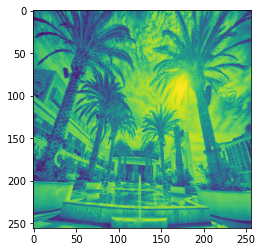

In [41]:
plt.imshow(simimg[0])

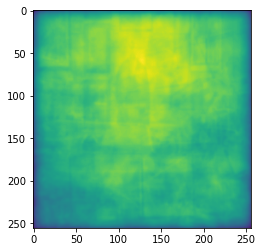

In [38]:
plt.imshow(inputimg[49])

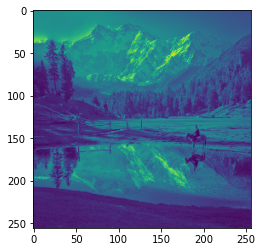

In [45]:
plt.imshow(gt[0])

In [37]:
plt.imshow(lr[0])

NameError: name 'lr' is not defined

In [118]:
lrt.shape,lrt.dtype,lrt.min(),lrt.max(),hrt.shape,hrt.dtype,hrt.min(),hrt.max(),hrt.unique()

(torch.Size([1, 1, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(0.5763),
 torch.Size([1, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 tensor([0., 1.]))

In [28]:
sr = net(inputimg.unsqueeze(0))
sr_numpy = sr.detach().numpy()
sr.shape,sr.min(),sr.max()

(torch.Size([1, 50, 256, 256]),
 tensor(-0.9056, grad_fn=<MinBackward1>),
 tensor(0.7544, grad_fn=<MaxBackward1>))

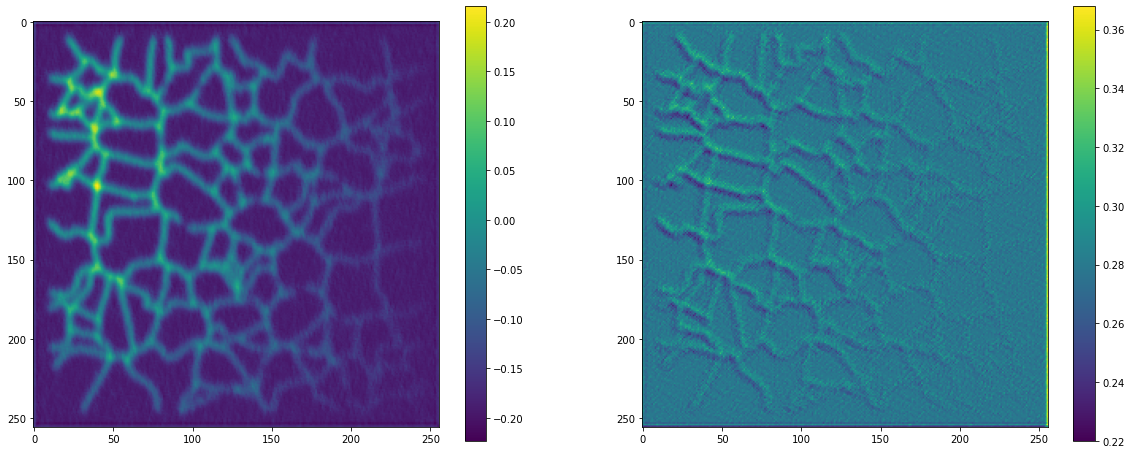

In [120]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sr_numpy[0,0,:,:])
plt.colorbar()
plt.subplot(122)
plt.imshow(sr_numpy[0,1,:,:])
plt.colorbar()
plt.show()

In [121]:
sr.shape,hrt.shape,hr.shape

(torch.Size([1, 2, 256, 256]), torch.Size([1, 256, 256]), (256, 256, 1))

In [122]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss = loss_function(sr, hrt.long())
# loss.backward()
# optimizer.step()

In [123]:
# Topo loss
layer = LevelSetLayer2D(size=(256,256), sublevel=False, maxdim=1)
# feat = SumBarcodeLengths(dim=1)
# feat = TopKBarcodeLengths(dim=1, k=2)
feat = BarcodePolyFeature(dim=0, p=1, q=1)
#     # creates a superlevel set layer on a 10-point line.
y = hrt.float()
dgm1,issub = layer(y)

y = sr.float().requires_grad_(True)

optimizer.zero_grad()

a = torch.exp(10*y)
b = torch.sum(a)
softmax = a/b
softmax[:,0,:,:] = softmax[:,0,:,:]*0
softmax[:,1,:,:] = softmax[:,1,:,:]*1
pred_labels = torch.sum(softmax,1,keepdim=True) # softargmax
dgm2,issub = layer(pred_labels)

loss_topo = torch.sum((dgm1[1]-dgm2[1])**2)

In [128]:
dgm1.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [43]:
total_loss = loss + loss_topo
total_loss.backward()
optimizer.step()

In [55]:
lrt[lrt < 0.2] = 0
lrt[lrt >= 0.2] = 1

tensor(61908)

# Batch mode

In [130]:
lr1,hr1 = np.load("G:/My Drive/01models/ER segmentation experiments July 2020/ER_brokenEdges_trainData_20200820/25.npy")
lr2,hr2 = np.load("G:/My Drive/01models/ER segmentation experiments July 2020/ER_brokenEdges_trainData_20200820/26.npy")
lr1.shape,hr1.shape,lr1.dtype,hr1.dtype,lr1.min(),lr1.max(),hr1.min(),hr1.max()

((256, 256, 1),
 (256, 256, 1),
 dtype('float64'),
 dtype('float64'),
 0.0,
 0.5762872891416034,
 0.0,
 1.0)

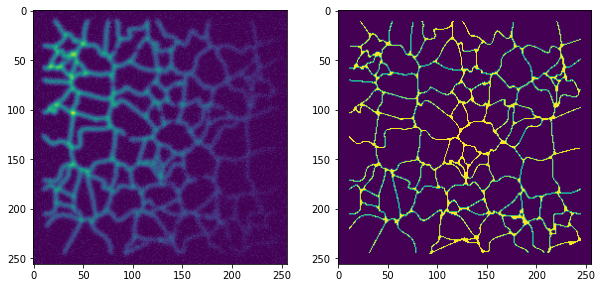

In [131]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(lr1[:,:,0])

plt.subplot(122)
plt.imshow(hr1[:,:,0])

plt.show()

In [171]:
import argparse
import models

opt = argparse.Namespace()
opt.n_resgroups = 3
opt.n_resblocks = 3
opt.n_feats = 64
opt.reduction = 16
opt.narch = 0
opt.scale = 1
opt.nch_in = 1
opt.nch_out = 1
opt.norm = ''
opt.task = 'denoise'
net = models.RCAN(opt)

lr = np.stack((lr1,lr2))
hr = np.stack((hr1,hr2))
lrt = torch.tensor(lr).permute(0,3,1,2).float()
hrt = torch.tensor(hr).permute(0,3,1,2).float()

not using normalization


In [172]:
lrt.shape,lrt.dtype,lrt.min(),lrt.max(),hrt.shape,hrt.dtype,hrt.min(),hrt.max(),hrt.unique()

(torch.Size([2, 1, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(0.5763),
 torch.Size([2, 1, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 tensor([0., 1.]))

In [173]:
sr = net(lrt)
sr_numpy = sr.detach().numpy()
sr.shape,sr.min(),sr.max()

(torch.Size([2, 1, 256, 256]),
 tensor(-0.1805, grad_fn=<MinBackward1>),
 tensor(0.0945, grad_fn=<MaxBackward1>))

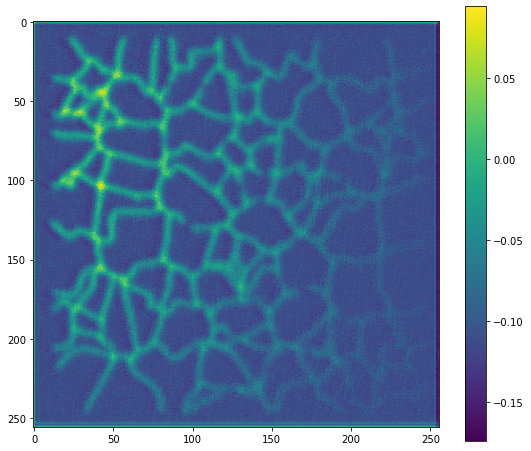

In [174]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sr_numpy[0,0,:,:])
plt.colorbar()
plt.show()

In [175]:
sr.shape,hrt.shape,hr.shape

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 256, 256]), (2, 256, 256, 1))

In [176]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss = loss_function(sr, hrt.long())
# loss.backward()
# optimizer.step()

In [199]:
# Topo loss
layer = LevelSetLayer2D(size=(256,256), sublevel=False, maxdim=1)
# feat = SumBarcodeLengths(dim=1)
# feat = TopKBarcodeLengths(dim=1, k=2)
feat = BarcodePolyFeature(dim=0, p=1, q=1)
#     # creates a superlevel set layer on a 10-point line.
y = hrt.float().view(2,256,256)
dgm1,issub = layer(y)

y = sr.float().requires_grad_(True)

optimizer.zero_grad()

dgm2,issub = layer(sr.view(2,256,256))

loss_topo = torch.sum((dgm1[1]-dgm2[1])**2)

In [200]:
loss_topo.backward()

RuntimeError: shape '[2, 256, 256]' is invalid for input of size 65536

In [185]:
dgm1[0].shape,dgm1[1].shape

(torch.Size([65536, 2]), torch.Size([130050, 2]))

In [184]:
total_loss = loss + loss_topo
total_loss.backward()
optimizer.step()

RuntimeError: shape '[2, 1, 256, 256]' is invalid for input of size 65536

In [3]:
import numpy as np
np.random.randn(3,3)

array([[ 0.42626134, -0.14316987,  1.39641066],
       [ 0.4180624 ,  0.7386256 , -0.54085642],
       [-2.26561367,  1.86853186, -1.52301355]])